# Fingers Count Classification (Q1 & 2)

In [17]:
import os
import re
import copy
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

plt.style.use('seaborn-v0_8')


In [18]:
# Reproducibility helpers

def set_seed(seed: int = 1337) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

BASE_DIR = Path('data-fingers')
TRAIN_DIR = BASE_DIR / 'train'
TEST_DIR = BASE_DIR / 'test'
assert TRAIN_DIR.exists() and TEST_DIR.exists(), 'Dataset folders not found'


Device: cuda


## Data preprocessing

In [20]:
LABEL_RE = re.compile(r"_(\d)[LR]\.png$", flags=re.IGNORECASE)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def parse_label(path: Path) -> int:
    match = LABEL_RE.search(path.name)
    if not match:
        raise ValueError(f'Cannot parse label from {path.name}')
    return int(match.group(1))


class FingersDataset(Dataset):
    def __init__(self, root, indices=None, transform=None):
        self.root = Path(root)
        self.transform = transform
        samples = [(p, parse_label(p)) for p in sorted(self.root.glob('*.png'))]
        if indices is not None:
            samples = [samples[i] for i in indices]
        if len(samples) == 0:
            raise RuntimeError(f'No samples found in {root}')
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


def build_transforms(image_size: int):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(12),
        transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.03),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    eval_tfms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
    return train_tfms, eval_tfms


def make_dataloaders(image_size=160, batch_size=64, val_split=0.15, num_workers=2):
    train_tfms, eval_tfms = build_transforms(image_size)
    base_dataset = FingersDataset(TRAIN_DIR)

    # Deterministic train/val split
    total = len(base_dataset)
    val_len = max(1, int(total * val_split))
    indices = torch.randperm(total, generator=torch.Generator().manual_seed(42)).tolist()
    val_idx = indices[:val_len]
    train_idx = indices[val_len:]

    train_ds = FingersDataset(TRAIN_DIR, indices=train_idx, transform=train_tfms)
    val_ds = FingersDataset(TRAIN_DIR, indices=val_idx, transform=eval_tfms)
    test_ds = FingersDataset(TEST_DIR, transform=eval_tfms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader, train_ds, val_ds, test_ds


### display the images from the fingers dataset

Train images: 15300, Val: 2700, Test: 3600


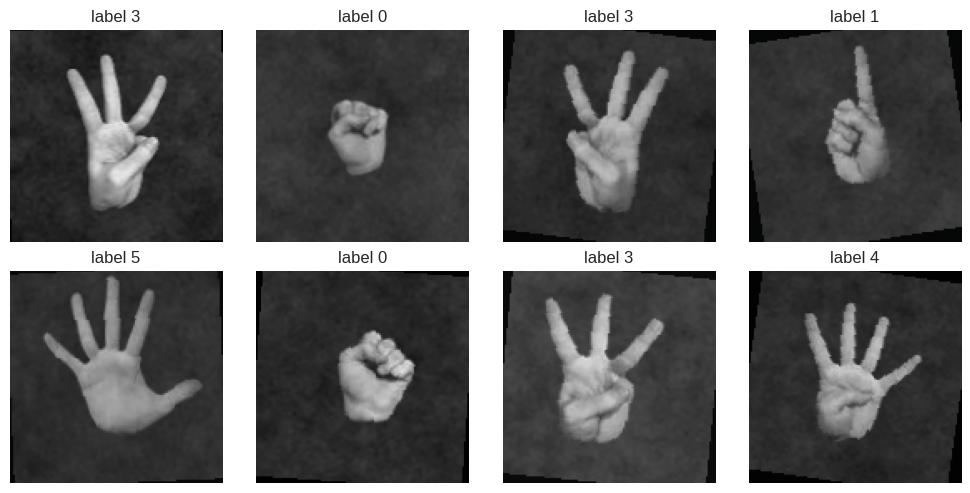

In [21]:
train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_dataloaders(image_size=128, batch_size=32)
print(f"Train images: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

imgs, labels = next(iter(train_loader))
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for ax, img, lbl in zip(axes.flatten(), imgs[:8], labels[:8]):
    img_np = img.permute(1, 2, 0).numpy() * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    ax.set_title(f'label {lbl.item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Model architectures


In [22]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, pool=False):
        super().__init__()
        padding = kernel_size // 2
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if pool:
            layers.append(nn.MaxPool2d(2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class FingerCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32, pool=True),
            ConvBlock(32, 64, pool=True),
            ConvBlock(64, 128, pool=True),
            ConvBlock(128, 256, pool=True),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.35),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


def make_resnet18(num_classes=6):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


## Training & evaluation helpers
- CrossEntropy loss + AdamW optimizer.
- Cosine annealing LR by default; adjust below as needed.
- We keep the best validation checkpoint in memory for testing.


In [23]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        preds = logits.argmax(dim=1)
        total_loss += loss.item() * labels.size(0)
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, total_correct / total


def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        preds = logits.argmax(dim=1)
        total_loss += loss.item() * labels.size(0)
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, total_correct / total


def train_model(model, train_loader, val_loader, epochs=12, lr=3e-4, weight_decay=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch:02d}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} train_acc={train_acc:.3f} val_acc={val_acc:.3f}")

    model.load_state_dict(best_state)
    return model, history, criterion


def plot_history(history, title='Training history'):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(epochs, history['train_loss'], label='train')
    axes[0].plot(epochs, history['val_loss'], label='val')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()

    axes[1].plot(epochs, history['train_acc'], label='train')
    axes[1].plot(epochs, history['val_acc'], label='val')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_ylim(0, 1)
    axes[1].set_title('Accuracy')
    axes[1].legend()
    fig.suptitle(title)
    plt.show()


def evaluate_on_test(model, loader, criterion, label_names=None):
    model.eval()
    all_true, all_pred = [], []
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            preds = logits.argmax(dim=1)
            total_loss += loss.item() * labels.size(0)
            all_true.extend(labels.cpu().tolist())
            all_pred.extend(preds.cpu().tolist())
    avg_loss = total_loss / len(all_true)
    acc = accuracy_score(all_true, all_pred)
    rec = recall_score(all_true, all_pred, average='macro')
    cm = confusion_matrix(all_true, all_pred, labels=list(range(6)))

    print(f"Test loss: {avg_loss:.4f}, accuracy: {acc:.4f}, macro recall: {rec:.4f}")
    print(classification_report(all_true, all_pred, target_names=label_names))
    return all_true, all_pred, cm


def plot_confusion(cm, classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()


## Train custom CNN (Question 1)
Adjust the hyperparameters below to trade off runtime vs accuracy. The defaults give a solid baseline while keeping the training short on CPU.


Epoch 01: train_loss=0.7253 val_loss=0.2018 train_acc=0.747 val_acc=0.981
Epoch 02: train_loss=0.2414 val_loss=0.5726 train_acc=0.924 val_acc=0.716
Epoch 03: train_loss=0.1491 val_loss=0.0378 train_acc=0.953 val_acc=0.998
Epoch 04: train_loss=0.0997 val_loss=0.0670 train_acc=0.972 val_acc=0.989
Epoch 05: train_loss=0.0691 val_loss=0.0120 train_acc=0.982 val_acc=1.000
Epoch 06: train_loss=0.0581 val_loss=0.0103 train_acc=0.986 val_acc=1.000


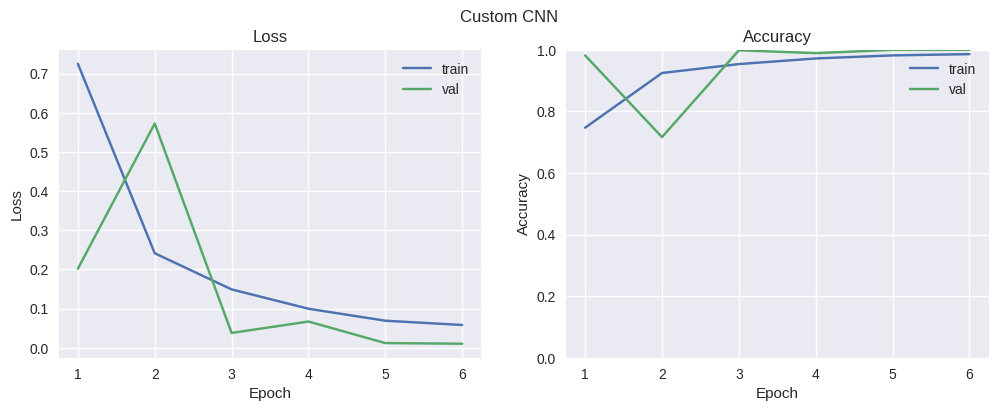

In [24]:
# Hyperparameters
cnn_image_size = 160
batch_size = 32 
num_epochs = 6  
learning_rate = 3e-4
weight_decay = 1e-4

# Data
train_loader, val_loader, test_loader, *_ = make_dataloaders(
    image_size=cnn_image_size, batch_size=batch_size, val_split=0.15, num_workers=2
)

# Model
cnn_model = FingerCNN(num_classes=6).to(device)
cnn_model, cnn_history, cnn_criterion = train_model(
    cnn_model, train_loader, val_loader, epochs=num_epochs, lr=learning_rate, weight_decay=weight_decay
)
plot_history(cnn_history, title='Custom CNN')


Test loss: 0.0137, accuracy: 0.9978, macro recall: 0.9978
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       0.99      1.00      0.99       600
           3       1.00      0.99      0.99       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



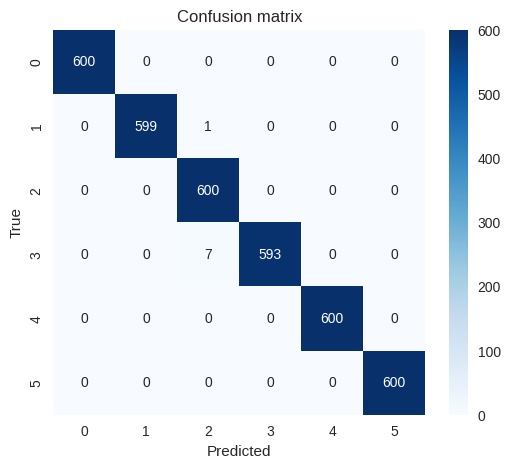

In [25]:
classes = [str(i) for i in range(6)]
cnn_true, cnn_pred, cnn_cm = evaluate_on_test(cnn_model, test_loader, cnn_criterion, label_names=classes)
plot_confusion(cnn_cm, classes)


## Train ResNet18 from scratch (Question 2)
We keep all preprocessing and hyperparameters the same, changing only the architecture and the input resize (224x224 is the canonical size for ResNet18).


Epoch 01: train_loss=0.1078 val_loss=0.2327 train_acc=0.965 val_acc=0.911
Epoch 02: train_loss=0.0129 val_loss=0.0001 train_acc=0.997 val_acc=1.000
Epoch 03: train_loss=0.0006 val_loss=0.0001 train_acc=1.000 val_acc=1.000
Epoch 04: train_loss=0.0004 val_loss=0.0000 train_acc=1.000 val_acc=1.000
Epoch 05: train_loss=0.0003 val_loss=0.0003 train_acc=1.000 val_acc=1.000
Epoch 06: train_loss=0.0004 val_loss=0.0000 train_acc=1.000 val_acc=1.000


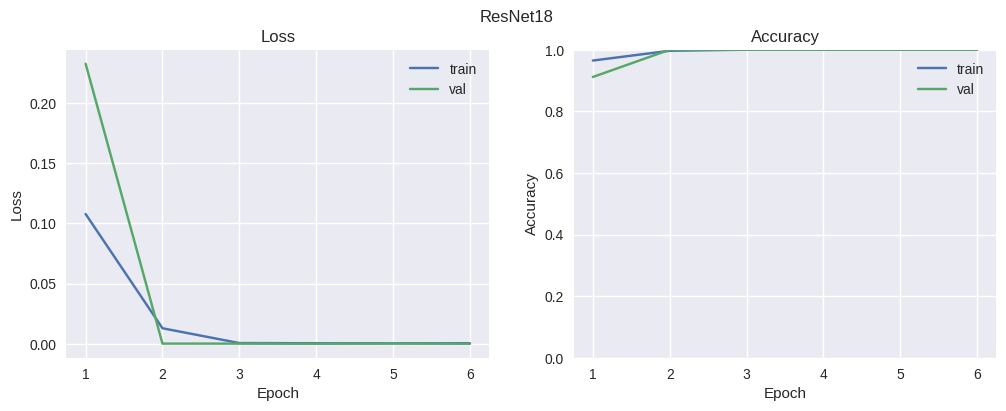

In [26]:
resnet_image_size = 224

train_loader_r, val_loader_r, test_loader_r, *_ = make_dataloaders(
    image_size=resnet_image_size, batch_size=batch_size, val_split=0.15, num_workers=2
)

resnet_model = make_resnet18(num_classes=6).to(device)
resnet_model, resnet_history, resnet_criterion = train_model(
    resnet_model, train_loader_r, val_loader_r, epochs=num_epochs, lr=learning_rate, weight_decay=weight_decay
)
plot_history(resnet_history, title='ResNet18')


Test loss: 0.0003, accuracy: 1.0000, macro recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



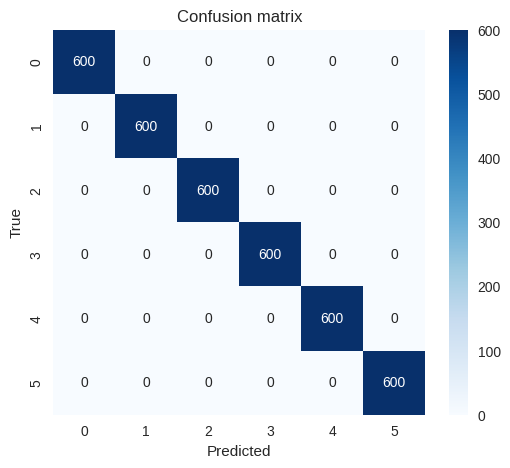

In [27]:
res_true, res_pred, res_cm = evaluate_on_test(resnet_model, test_loader_r, resnet_criterion, label_names=classes)
plot_confusion(res_cm, classes)


## Model comparison
Overlay validation accuracy curves to compare convergence, and summarize the test metrics.


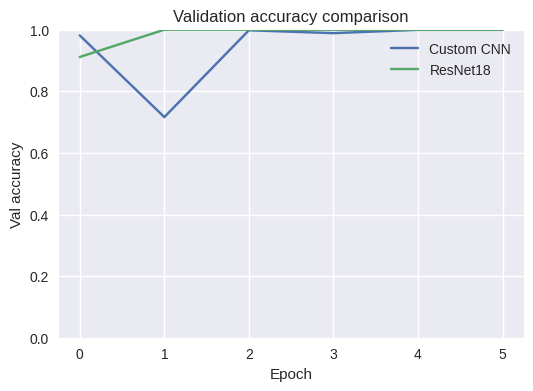

,model,test_accuracy,test_recall_macro
0,Custom CNN,0.997778,0.997778
1,ResNet18,1.000000,1.000000


In [28]:
plt.figure(figsize=(6, 4))
plt.plot(cnn_history['val_acc'], label='Custom CNN')
plt.plot(resnet_history['val_acc'], label='ResNet18')
plt.xlabel('Epoch')
plt.ylabel('Val accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title('Validation accuracy comparison')
plt.show()

summary = pd.DataFrame([
    {
        'model': 'Custom CNN',
        'test_accuracy': accuracy_score(cnn_true, cnn_pred),
        'test_recall_macro': recall_score(cnn_true, cnn_pred, average='macro'),
    },
    {
        'model': 'ResNet18',
        'test_accuracy': accuracy_score(res_true, res_pred),
        'test_recall_macro': recall_score(res_true, res_pred, average='macro'),
    },
])
summary
